## Phase02-IEEE IFS-TC Image Forensics Challenge

In the previous notebook,we have tried to classify whether an image is real or fake through Error Level Analysis using CASIA dataset.
(Phase-01 of the Forensics challenge)



* This is a rough implementation of phase-02 of the forensics challenge


* Research Paper: http://openaccess.thecvf.com/content_cvpr_2018/papers/Zhou_Learning_Rich_Features_CVPR_2018_paper.pdf

### Dataset source: 

Download the dataset from here: http://web.archive.org/web/20171013200331/http://ifc.recod.ic.unicamp.br/fc.website/index.py?sec=5

### Approaches used :

Two main approaches are used to find the exact tampered region of fake images and they are as follows:

**1)**  Unet model : train it with input:ERROR LEVEL ANALYSIS(**ELA**) of fake images and output:Ground Truth Masks. 


**2)** Using local noise features based methods, like the
steganalysis rich model (**SRM**) along with Fake images to train


input:Fake Image,Noise filter ,output: Ground Truth Mask

**Data Augmentation** also has been used in this assignment since the dataset size is small.

The terminologies used in the paper:

**Fake image**: An image that has been manipulated/doctored using the two most common manipulation operations namely: copy/pasting and image splicing.

**Pristine image**: An image that has not been manipulated except for the resizing needed to bring all images to a standard size as per competition rules.


**Image splicing**: The splicing operations can combine images of people, adding doors to buildings, adding trees and cars to parking lots etc. The spliced images can also contain resulting parts from copy/pasting operations. The image receiving a spliced part is called a “host” image. The parts being spliced together with the host image are referred to as “aliens”.

### 1) Using ELA

In [2]:
# Import Libraries 

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import PIL
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib
from PIL import Image, ImageChops, ImageEnhance
from skimage.io import imread
from skimage import exposure, color
from skimage.transform import resize
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from itertools import chain
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from numpy import save,load


from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.optimizers import Adam,SGD
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model

from keras.applications.resnet import ResNet50
from keras.applications.resnet import ResNet101

from sklearn.metrics import roc_curve, auc,roc_auc_score

from tqdm import tqdm
import cv2

from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate


Using TensorFlow backend.


### Overview:

Image forgery localization is one of the most challenging
tasks in digital image forensics. Different from forgery
detection which simply discriminates whether a given image is pristine or fake, image forgery localization attempts
to detect the accurate tampered areas. 


In [91]:
path_original = '/home/ubuntu/Downloads/phase-01-training/dataset-dist/phase-01/training/pristine/'
path_tampered = '/home/ubuntu/Downloads/phase-01-training/dataset-dist/phase-01/training/fake/'
dataset_path = '/home/ubuntu/Downloads/phase-01-training/dataset-dist/phase-01/training/'
total_original = os.listdir(path_original)
total_tampered = os.listdir(path_tampered)


In [92]:
#https://stackoverflow.com/questions/47645115/oserror-cannot-identify-image-file-dataset-ds-store
total_tampered.remove('.DS_Store')


In [93]:
print('total number of pristine and tampered images are respectively:',len(total_original),',',len(total_tampered))

total number of pristine and tampered images are respectively: 1050 , 900


In [3]:
#saving the path along with the file names
pristine_images = []
for i in total_original:
    pristine_images.append(dataset_path+i)
fake_images = []
for i in total_tampered:
    fake_images.append(dataset_path+i)

In [4]:
total_tampered[0:5]

['ae9dbc1d83a6063f921c7b6f19ecc468.png',
 'deb7cc4263e3dc9a640c57c7b2f714fd.png',
 'da87f75ad935467d3c8d0ab08a559e76.png',
 'd507e807f025f09ea0cff40b52e9322c.mask.png',
 'aa61a96b0a18b8dbc65fd20af3644958.mask.png']

In [5]:
def mask_pristine(path):
    img = Image.open(path).convert("RGB")
    img_shape=(np.array(img)).shape
    return np.ones((img_shape))*255

def plot_ground_truth_mask(image,fake=True):
    if fake:
        PATH=path_tampered+image.replace('.mask','')
    else:
        PATH=path_original+image

    PATH_mask=PATH[:-3]+'mask.png'
    
    img = Image.open(PATH).convert("RGB")
    
    try:
        mask_img=Image.open(PATH_mask).convert("RGB")
    except:
        mask_img=mask_pristine(PATH)
    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax1.set_title("Image")
    ax2.set_title("Ground Truth Mask")
    ax1.imshow(img)
    ax2.imshow(mask_img)


In [6]:
'd507e807f025f09ea0cff40b52e9322c.mask.png'.replace('.mask','')[0:-4]

'd507e807f025f09ea0cff40b52e9322c'

### Tampered Image

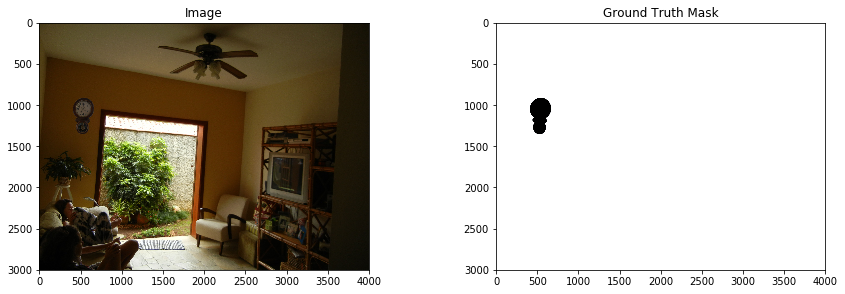

In [7]:
plot_ground_truth_mask(total_tampered[2])

* The clock on the wall is fake

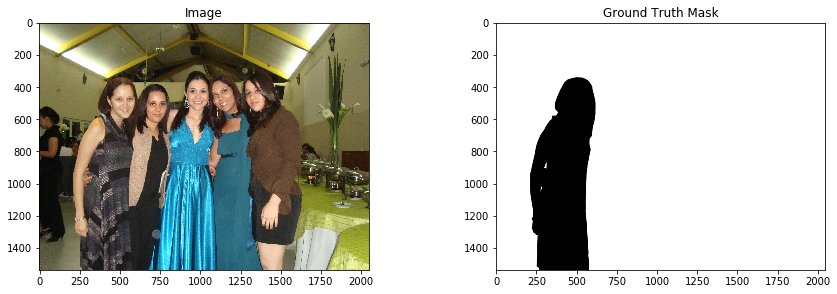

In [8]:
plot_ground_truth_mask(total_tampered[4])

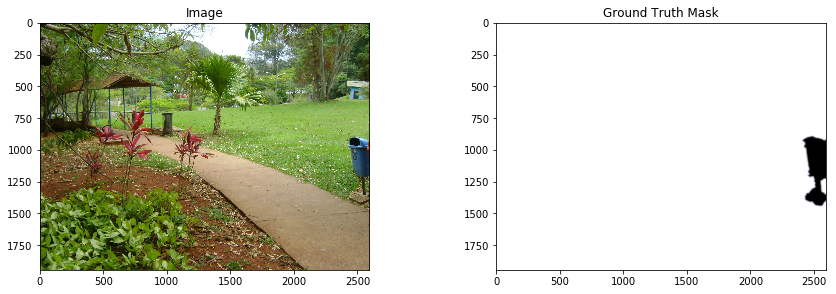

In [10]:
plot_ground_truth_mask(total_tampered[7])

* So  from the ground  truth mask we get the portion of the image which got tampered.

### Pristine Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


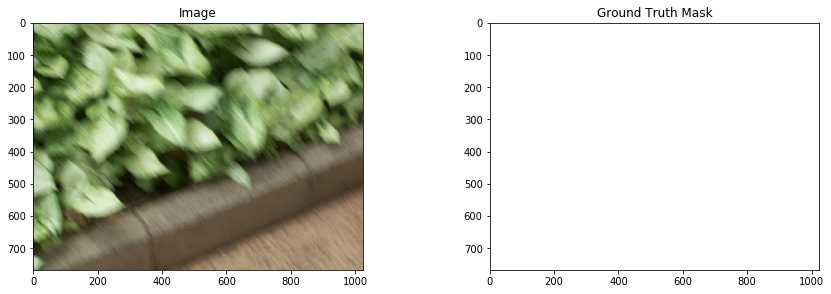

In [9]:
plot_ground_truth_mask(total_original[5],fake=False)

In [54]:
len(total_tampered)

900

In [15]:
if not os.path.exists(dataset_path+"resized_images/"):
    os.makedirs(dataset_path+"resized_images/fake_masks/")
    os.makedirs(dataset_path+"resized_images/image/fake_images/")
    os.makedirs(dataset_path+"resized_images/image/pristine_images/")
    height = 512
    width = 512
    for fake_image in tqdm(total_tampered):
        
        if('.mask' in fake_image):
            img=Image.open(path_tampered + fake_image).convert("RGB")
            
        
            img = img.resize((height, width), PIL.Image.ANTIALIAS)
            img.save(dataset_path+"resized_images/fake_masks/"+fake_image)
        else:
            
            img=Image.open(path_tampered + fake_image).convert("RGB")
            
            img = img.resize((height, width), PIL.Image.ANTIALIAS)
            img.save(dataset_path+"resized_images/image/fake_images/"+fake_image)
            
    for pristine_image in tqdm(total_original):
        img=Image.open(path_original + pristine_image).convert("RGB")
        
        img = img.resize((height, width), PIL.Image.ANTIALIAS)
        img.save(dataset_path+"resized_images/image/pristine_images/"+pristine_image)
        
        
else:
    print('images resized,path exists')

100%|██████████| 1050/1050 [01:50<00:00,  9.49it/s]


In [17]:
len(os.listdir(dataset_path+"resized_images/image/pristine_images/"))

1050

In [23]:
resized_fakes = os.listdir(dataset_path+"resized_images/image/fake_images/")

In [25]:
resized_fake_path = dataset_path+"resized_images/image/fake_images/"

In [24]:
len(resized_fakes)

450

In [18]:
#augmentation

### Approaches used:


* Image Augmentation using albumentations module
* Find ELA of tampered image and convert it to array. This becomes the input X for training.
* Use the corresponding Ground Truth mask as the class label.
* The model will try to predict the tampered region using X and Y

### Data Augmentation

* We want our CNN model to be robust to things like rotation,zoom,shift,shear and other operations on images.
* Since the number of images in the dataset provided to us is not sufficient enough,we make use of Image Augmentation to generate more data.

Data Augmentation using Albumentation Library
* citation link:https://github.com/albumentations-team/albumentations#pypi

* It is a fast image augmentation library and easy to use wrapper around other libraries


In [3]:
#pip install albumentations

Let's now get the ELA images our 512X512X3 images 

Citation link: https://researchweb.iiit.ac.in/~anurag.ghosh/static/detection-localization-image.pdf

* Error Level Analysis: 
It works by intentionally resaving the JPEG image at
a known error rate and then computing the difference between the images. Any modification to the picture will alter
the image such that stable areas become unstable. Differently compressed versions of the image are compared with
the possibly tampered one.

* ELA exploits the lossy compression of JPEG images. When an image is altered, the compression ratio of the specific portion changes with respect to other parts. 
http://www.hackerfactor.com/papers/bh-usa-07-krawetz-wp.pdf






#### ==========================================================
Here's an amazing online tool you can use to understand how it works:

* https://29a.ch/photo-forensics/#error-level-analysis 

* Click open file and experiment it with your own set of images

#### ==========================================================

In [8]:
#https://gist.github.com/cirocosta/33c758ad77e6e6531392
#error level analysis of an image
def ELA(img_path):
    """Performs Error Level Analysis over a directory of images"""
    
    TEMP = 'ela_' + 'temp.jpg'
    SCALE = 10
    original = Image.open(img_path)
    try:
        original.save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original, temporary)
        
    except:
        
        original.convert('RGB').save(TEMP, quality=90)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original.convert('RGB'), temporary)
        
       
    d = diff.load()
    
    WIDTH, HEIGHT = diff.size
    for x in range(WIDTH):
        for y in range(HEIGHT):
            d[x, y] = tuple(k * SCALE for k in d[x, y])
#     save_path = dataset_path +'ELA_IMAGES/'
#     diff.save(save_path+'diff.png')
    return diff


In [26]:
if not os.path.exists(dataset_path+'ELA_IMAGES/'):
    os.makedirs(dataset_path+'ELA_IMAGES/')
    for i in tqdm(resized_fakes):
        ELA(resized_fake_path+i).save(dataset_path+'ELA_IMAGES/'+i)
else:
    print('Images are already converted to ELA')

    


100%|██████████| 450/450 [02:19<00:00,  3.14it/s]


In [31]:
#Files with the whole path:
[dataset_path+"resized_images/fake_masks/"+i for i in os.listdir(dataset_path+"resized_images/fake_masks/") ][0:10]

['/home/ubuntu/Downloads/phase-01-training/dataset-dist/phase-01/training/resized_images/fake_masks/d507e807f025f09ea0cff40b52e9322c.mask.png',
 '/home/ubuntu/Downloads/phase-01-training/dataset-dist/phase-01/training/resized_images/fake_masks/aa61a96b0a18b8dbc65fd20af3644958.mask.png',
 '/home/ubuntu/Downloads/phase-01-training/dataset-dist/phase-01/training/resized_images/fake_masks/a0942fb0a31b0f782d5d67a92e6f782c.mask.png',
 '/home/ubuntu/Downloads/phase-01-training/dataset-dist/phase-01/training/resized_images/fake_masks/8330772517186ab2c21c9e80ddd3daf1.mask.png',
 '/home/ubuntu/Downloads/phase-01-training/dataset-dist/phase-01/training/resized_images/fake_masks/ac23beb47b46fdc24e2f381be0aa6762.mask.png',
 '/home/ubuntu/Downloads/phase-01-training/dataset-dist/phase-01/training/resized_images/fake_masks/a343124f546ea20b08092f6d2e72554f.mask.png',
 '/home/ubuntu/Downloads/phase-01-training/dataset-dist/phase-01/training/resized_images/fake_masks/ce6a3e19dfcd8e8b162faf8511b920ae.mas

In [5]:
ELA_images_with_path = [dataset_path+'ELA_IMAGES/'+i for i in os.listdir(dataset_path+'ELA_IMAGES/') ]
fake_mask_with_path = [dataset_path+"resized_images/fake_masks/"+i for i in os.listdir(dataset_path+"resized_images/fake_masks/") ]

In [6]:
ELA_images_with_path.sort()

In [7]:
fake_mask_with_path.sort()

In [8]:
fake_mask_with_path[0]

'/home/ubuntu/Downloads/phase-01-training/dataset-dist/phase-01/training/resized_images/fake_masks/010543abfbd0db1e9aa1b24604336e0c.mask.png'

In [9]:
ELA_images_with_path[0]

'/home/ubuntu/Downloads/phase-01-training/dataset-dist/phase-01/training/ELA_IMAGES/010543abfbd0db1e9aa1b24604336e0c.png'

In [28]:
total_tampered.sort()

In [29]:
total_tampered[0]

'010543abfbd0db1e9aa1b24604336e0c.mask.png'

In [15]:
def ela_and_mask(index):
   
    fig = plt.figure(figsize=(15,10))
    ax1 = fig.add_subplot(331)
    ax2 = fig.add_subplot(332)
    ax3 = fig.add_subplot(333)
    ax1.set_title("tampered")
    ax2.set_title("ELA")
    ax3.set_title("Ground Truth Mask")
    
    ela_fake = Image.open(ELA_images_with_path[index])
    fake_mask = Image.open(fake_mask_with_path[index])
    tampered_image = Image.open(path_tampered+ELA_images_with_path[index][83:])
    ax1.imshow(tampered_image)
    ax2.imshow(ela_fake)
    ax3.imshow(fake_mask)
    

In [85]:
len('/home/ubuntu/Downloads/phase-01-training/dataset-dist/phase-01/training/ELA_IMAGES/')

83

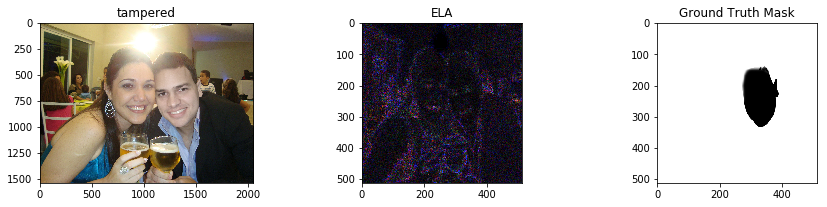

In [20]:
ela_and_mask(0)

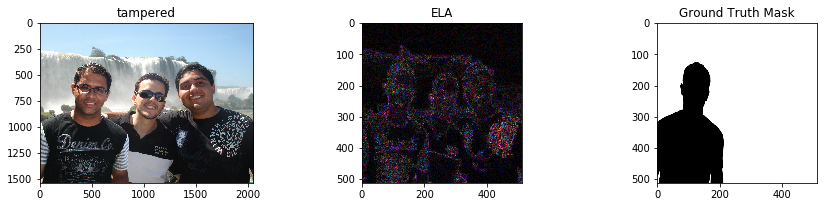

In [91]:
ela_and_mask(10)

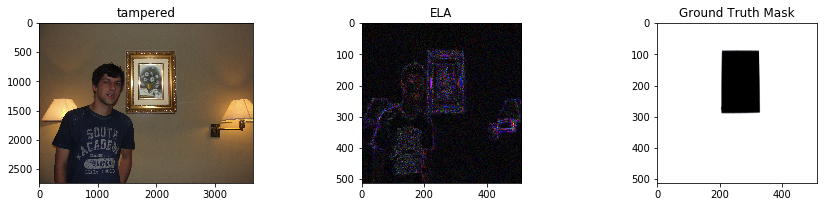

In [96]:
ela_and_mask(6)

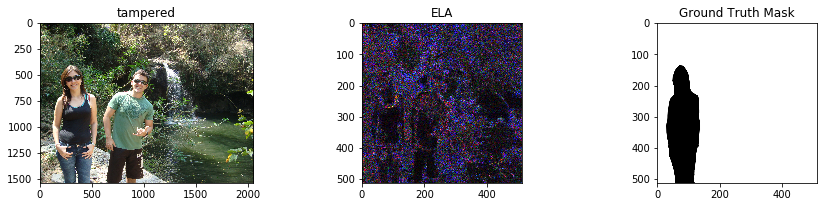

In [30]:
ela_and_mask(45)

In [10]:
len(ELA_images_with_path),len(fake_mask_with_path)

(450, 450)

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(ELA_images_with_path,fake_mask_with_path , test_size=0.12, random_state=7)


In [12]:
#citation: https://albumentations.readthedocs.io/en/latest/examples.html
#https://github.com/albumentations-team/albumentations/blob/master/notebooks/example.ipynb


# the following code is copied directly from the documentation site : 



## https://github.com/albu/albumentations




from albumentations import *

def strong_aug(p=1):
    return Compose([
        RandomRotate90(),
        
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=.1),
            Blur(blur_limit=3, p=.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomContrast(),

        ], p=0.3),

    ], p=p)

def aug_with_crop(crop_prob = 1):
    return Compose([

        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomRotate90(p=0.5),
        Transpose(p=0.5),
        ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
        RandomBrightnessContrast(p=0.5),

        IAAEmboss(p=0.25),
        Blur(p=0.01, blur_limit = 3),
        OneOf([
            ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
            GridDistortion(p=0.5),
            OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
        ], p=0.8)
    ], p = 1)

def augment_flips_color(p=.5):
    return Compose([
        CLAHE(),
        RandomRotate90(),
        Transpose(),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
        Blur(blur_limit=3),
        OpticalDistortion(),
        GridDistortion(),

    ], p=p)

def aug_data_1(p=.5):
    return Compose([
        CLAHE(),
        Transpose(),
        Blur(blur_limit=3),
        OpticalDistortion(),
        ElasticTransform(),
        HueSaturationValue()
    ], p=p)

def aug_data_2(p=.5):
    return Compose([
        CLAHE(),
        Blur(blur_limit=3),
        GridDistortion(),
        ElasticTransform(),
        HueSaturationValue()
    ], p=p)




In [33]:
X_val[45]

'/home/ubuntu/Downloads/phase-01-training/dataset-dist/phase-01/training/ELA_IMAGES/a67721b7b84cb6e9649c67168d02274b.png'

In [15]:
def horizontalFlip(image,mask):
    aug = HorizontalFlip(p=1)
    augmented = aug(image=image, mask=mask)
    image_hflip = augmented['image']
    mask_hflip = augmented['mask']
    return image_hflip,mask_hflip

def verticalFlip(image,mask):
    aug = VerticalFlip(p=1)
    augmented = aug(image=image, mask=mask)
    image_vflip = augmented['image']
    mask_vflip = augmented['mask']
    return image_vflip,mask_vflip
    
def randomRotate(image,mask):
    aug = RandomRotate90(p=1)
    augmented = aug(image=image, mask=mask)
    image_rot90 = augmented['image']
    mask_rot90 = augmented['mask']
    return image_rot90,mask_rot90
    
def transpose(image,mask):
    aug = Transpose(p=1)
    augmented = aug(image=image, mask=mask)
    image_transpose = augmented['image']
    mask_transpose = augmented['mask']
    return image_transpose,mask_transpose

def elasticDistortion(image,mask):
    aug = ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
    augmented = aug(image=image, mask=mask)
    image_ed = augmented['image']
    mask_ed = augmented['mask']
    return image_ed,mask_ed



In [35]:
Y_val[45]

'/home/ubuntu/Downloads/phase-01-training/dataset-dist/phase-01/training/resized_images/fake_masks/a67721b7b84cb6e9649c67168d02274b.mask.png'

In [16]:
def opticalDistortion(image,mask):
    aug = OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)
    augmented = aug(image=image, mask=mask)
    image_od = augmented['image']
    mask_od = augmented['mask']
    return image_od,mask_od

def gridDistortion(image,mask):
    aug = GridDistortion()
    augmented = aug(image=image, mask=mask)
    image_od = augmented['image']
    mask_od = augmented['mask']
    return image_od,mask_od

def strong_Aug(image,mask):
    aug = strong_aug(p=1)
    augmented = aug(image=image, mask=mask)
    image_od = augmented['image']
    mask_od = augmented['mask']
    return image_od,mask_od

def aug_with_Crop(image,mask):
    aug = aug_with_crop()
    augmented = aug(image=image, mask=mask)
    image_od = augmented['image']
    mask_od = augmented['mask']
    return image_od,mask_od

def augment_flips_Color(image,mask):
    aug = augment_flips_color()
    image_od = aug(image=image)['image']
    mask_od = aug(image=mask)['image']

    return image_od,mask_od

def aug_Data_1(image,mask):
    aug = aug_data_1()

    image_od = aug(image=image)['image']
    mask_od = aug(image=mask)['image']

    return image_od,mask_od

def aug_Data_2(image,mask):
    aug = aug_data_2()

    image_od = aug(image=image)['image']
    mask_od = aug(image=mask)['image']

    return image_od,mask_od


In [17]:
def channelShuffle(image,mask):
    aug = ChannelShuffle(p=1)
    augmented = aug(image=image, mask=mask)
    image_od = augmented['image']
    mask_od = augmented['mask']
    return image_od,mask_od

def randomBrightness(image,mask):

    aug = RandomBrightness()

    image_od = aug(image=image)['image']
    mask_od = aug(image=mask)['image']

    return image_od,mask_od

def rotate(image,mask):

    aug = Rotate()
    augmented = aug(image=image, mask=mask)
    image_od = augmented['image']
    mask_od = augmented['mask']
    return image_od,mask_od
  
def rGBShift(image,mask):

    aug = RGBShift()
    augmented = aug(image=image, mask=mask)
    image_od = augmented['image']
    mask_od = augmented['mask']
    return image_od,mask_od

def randomGamma(image,mask):
   
    aug = RandomGamma()
    augmented = aug(image=image, mask=mask)
    image_od = augmented['image']
    mask_od = augmented['mask']
    return image_od,mask_od

def flip(image,mask):
    aug = Flip()
    augmented = aug(image=image, mask=mask)
    image_od = augmented['image']
    mask_od = augmented['mask']
    return image_od,mask_od



def hueSaturationValue(image,mask):
   
    aug = HueSaturationValue()
    augmented = aug(image=image, mask=mask)
    image_od = augmented['image']
    mask_od = augmented['mask']
    return image_od,mask_od


In [18]:
train_data = [i for i in X_train]

In [19]:
mask_data = [i for i in Y_train]

In [81]:
image = cv2.imread(train_data[3]);mask = cv2.imread(mask_data[3]) #converts the image into array

In [82]:
image_aug = horizontalFlip(image,mask)[0]  #augmenting operation
mask_aug = horizontalFlip(image,mask)[1]

In [80]:
len(horizontalFlip(image,mask))

2

Horizontal Flip


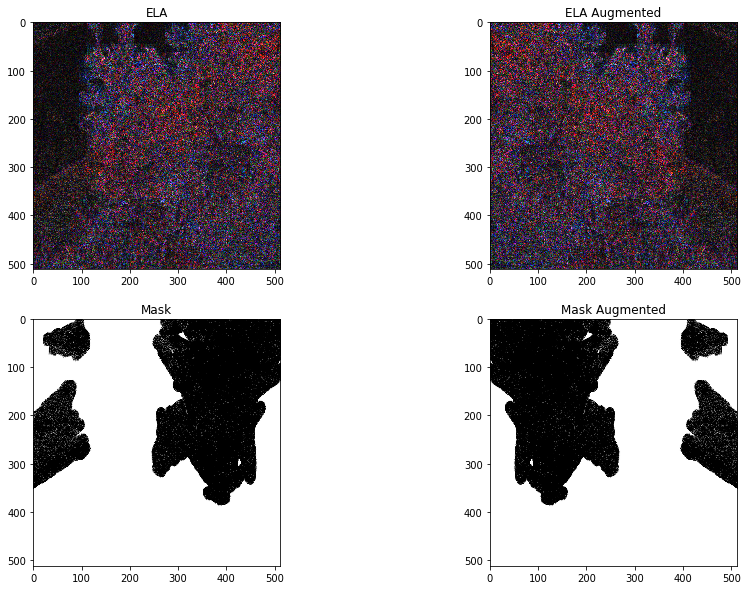

In [85]:
print('Horizontal Flip')
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.set_title("ELA")
ax2.set_title("ELA Augmented")
ax3.set_title("Mask")
ax4.set_title("Mask Augmented")
ax1.imshow(image)
ax2.imshow(image_aug)
ax3.imshow(mask)
ax4.imshow(mask_aug)


In [93]:
image_aug = opticalDistortion(image,mask)[0] #augmenting operation
mask_aug = opticalDistortion(image,mask)[1]

Optical Distortion


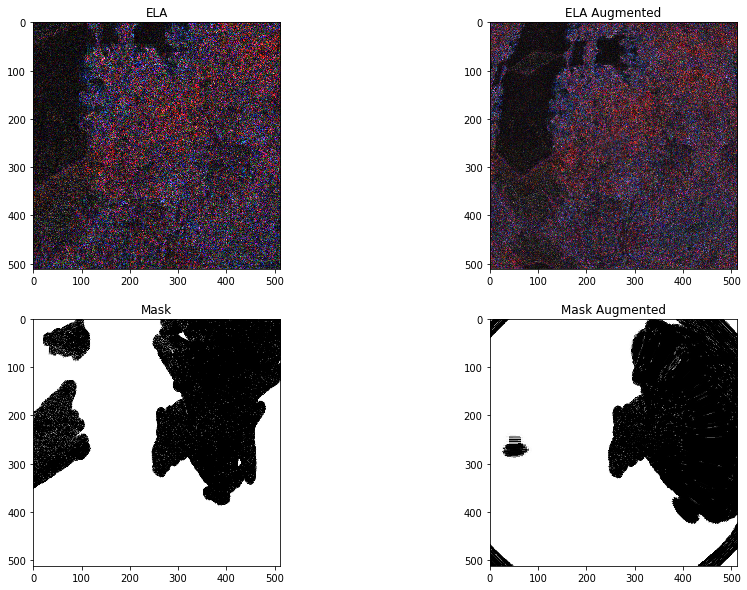

In [95]:
print('Optical Distortion')
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.set_title("ELA")
ax2.set_title("ELA Augmented")
ax3.set_title("Mask")
ax4.set_title("Mask Augmented")
ax1.imshow(image)
ax2.imshow(image_aug)
ax3.imshow(mask)
ax4.imshow(mask_aug)


In [101]:
image_aug = rGBShift(image,mask)[0]  #augmenting operation
mask_aug = rGBShift(image,mask)[1]

rgb shift


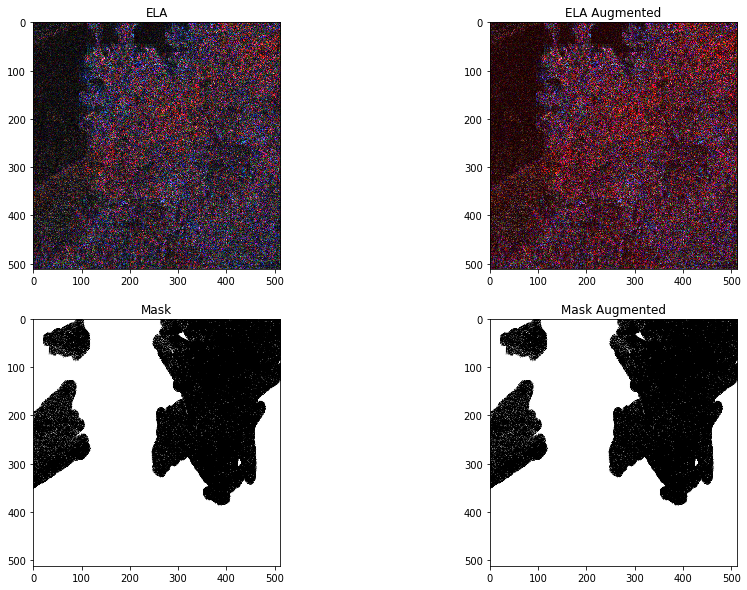

In [103]:
print('rgb shift')
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.set_title("ELA")
ax2.set_title("ELA Augmented")
ax3.set_title("Mask")
ax4.set_title("Mask Augmented")
ax1.imshow(image)
ax2.imshow(image_aug)
ax3.imshow(mask)
ax4.imshow(mask_aug)


In [104]:
image_aug = gridDistortion(image,mask)[0]  #augmenting operation
mask_aug = gridDistortion(image,mask)[1]

gridDistortion


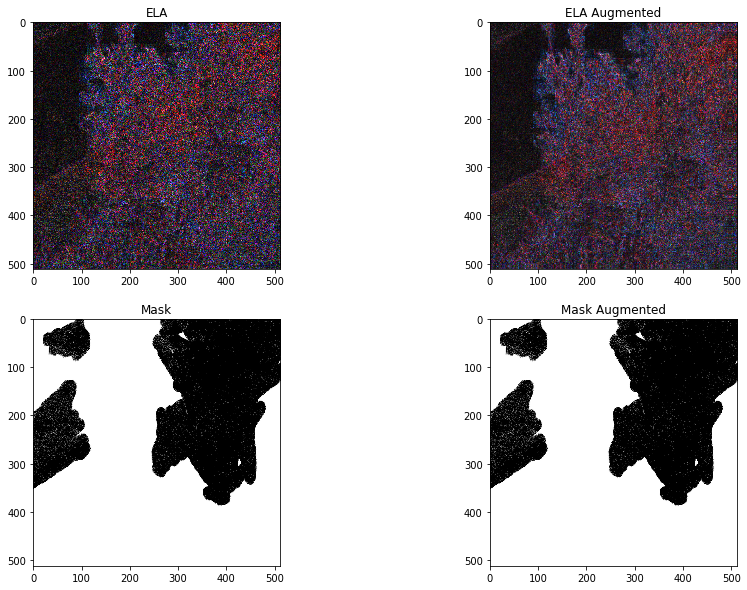

In [111]:
print('gridDistortion')
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.set_title("ELA")
ax2.set_title("ELA Augmented")
ax3.set_title("Mask")
ax4.set_title("Mask Augmented")
ax1.imshow(image)
ax2.imshow(image_aug)
ax3.imshow(mask)
ax4.imshow(mask_aug)


In [22]:
len(train_data),len(mask_data)

(396, 396)

In [21]:
if not os.path.isfile(dataset_path+"phase2/"):
    os.makedirs(dataset_path+"phase2/ela_aug/")
    os.makedirs(dataset_path+"phase2/mask_aug/")

In [23]:
######Performing various types of augmentations on Train data



for i in tqdm(range(len(train_data))):
    
  
    image=cv2.imread(train_data[i]);mask=cv2.imread(mask_data[i])
    ela_name = train_data[i][83:] ; mask_name = train_data[i][83:].replace('.png','.mask.png')
    
    Image.fromarray(image).save(dataset_path+'phase2/ela_aug/'+ 'or_' +  ela_name)  
    Image.fromarray(image).save(dataset_path+'phase2/mask_aug/'+ 'or_'+ mask_name)

    
    
  
    fl=flip(image,mask)
    Image.fromarray(fl[0]).save(dataset_path+'phase2/ela_aug/'+ 'fl_' + ela_name)
    Image.fromarray(fl[1]).save(dataset_path+'phase2/mask_aug/'+ 'fl_' + mask_name)



    hf=horizontalFlip(image,mask)       
    Image.fromarray(hf[0]).save(dataset_path+'phase2/ela_aug/'+ 'hf_' + ela_name)
    Image.fromarray(hf[1]).save(dataset_path+'phase2/mask_aug/'+ 'hf_' + mask_name)


    vf=verticalFlip(image,mask)
    Image.fromarray(vf[0]).save(dataset_path+'phase2/ela_aug/'+ 'vf_' + ela_name)
    Image.fromarray(vf[1]).save(dataset_path+'phase2/mask_aug/'+ 'vf_' + mask_name)


    tp=transpose(image,mask)
    Image.fromarray(tp[0]).save(dataset_path+'phase2/ela_aug/'+ 'tp_' + ela_name)
    Image.fromarray(tp[1]).save(dataset_path+'phase2/mask_aug/'+ 'tp_' + mask_name)


    rr=randomRotate(image,mask)
    Image.fromarray(rr[0]).save(dataset_path+'phase2/ela_aug/'+ 'rr_' + ela_name)
    Image.fromarray(rr[1]).save(dataset_path+'phase2/mask_aug/'+ 'rr_' + mask_name)


    od=opticalDistortion(image,mask)
    Image.fromarray(od[0]).save(dataset_path+'phase2/ela_aug/'+ 'od_' + ela_name)
    Image.fromarray(od[1]).save(dataset_path+'phase2/mask_aug/'+ 'od_' + mask_name)


    ed=elasticDistortion(image,mask)
    Image.fromarray(ed[0]).save(dataset_path+'phase2/ela_aug/'+ 'ed_' + ela_name)
    Image.fromarray(ed[1]).save(dataset_path+'phase2/mask_aug/'+ 'ed_' + mask_name)


    sa=strong_Aug(image,mask)
    Image.fromarray(sa[0]).save(dataset_path+'phase2/ela_aug/'+ 'sa_' + ela_name)
    Image.fromarray(sa[1]).save(dataset_path+'phase2/mask_aug/'+ 'sa_' + mask_name)


    ch=channelShuffle(image,mask)
    Image.fromarray(ch[0]).save(dataset_path+'phase2/ela_aug/'+ 'ch_' + ela_name)
    Image.fromarray(ch[1]).save(dataset_path+'phase2/mask_aug/'+ 'ch_' + mask_name)


    ac=aug_with_Crop(image,mask)
    Image.fromarray(ac[0]).save(dataset_path+'phase2/ela_aug/'+ 'ac_' + ela_name)
    Image.fromarray(ac[1]).save(dataset_path+'phase2/mask_aug/'+ 'ac_' + mask_name)


    af=augment_flips_Color(image,mask)
    Image.fromarray(af[0]).save(dataset_path+'phase2/ela_aug/'+ 'af_' + ela_name)
    Image.fromarray(af[1]).save(dataset_path+'phase2/mask_aug/'+ 'af_' + mask_name)


    gd=gridDistortion(image,mask)
    Image.fromarray(gd[0]).save(dataset_path+'phase2/ela_aug/'+ 'gd_' + ela_name)
    Image.fromarray(gd[1]).save(dataset_path+'phase2/mask_aug/'+ 'gd_' + mask_name)


    ad=aug_Data_1(image,mask)
    Image.fromarray(ad[0]).save(dataset_path+'phase2/ela_aug/'+ 'ad_' + ela_name)
    Image.fromarray(ad[1]).save(dataset_path+'phase2/mask_aug/'+ 'ad_' + mask_name)


#     ad2=aug_Data_2(image,mask)
#     Image.fromarray(ad2[0]).save(dataset_path+'phase2/ela_aug/'+ 'd2_' + ela_name)
#     Image.fromarray(ad2[1]).save(dataset_path+'phase2/mask_aug/'+ 'd2_' + mask_name)


    
#     hs=hueSaturationValue(image,mask)
#     Image.fromarray(hs[0]).save(dataset_path+'phase2/ela_aug/'+ 'hs_' + ela_name)
#     Image.fromarray(hs[1]).save(dataset_path+'phase2/mask_aug/'+ 'hs_' + mask_name)


#     rb=randomBrightness(image,mask)
#     Image.fromarray(rb[0]).save(dataset_path+'phase2/ela_aug/'+ 'rb_' + ela_name)
#     Image.fromarray(rb[1]).save(dataset_path+'phase2/mask_aug/'+ 'rb_' + mask_name)

#     r=rotate(image,mask)
#     Image.fromarray(r[0]).save(dataset_path+'phase2/ela_aug/'+ 'r_' + ela_name)
#     Image.fromarray(r[1]).save(dataset_path+'phase2/mask_aug/'+ 'r_' + mask_name)

#     rgb=rGBShift(image,mask)
#     Image.fromarray(rgb[0]).save(dataset_path+'phase2/ela_aug/'+ 'rg_' + ela_name)
#     Image.fromarray(rgb[1]).save(dataset_path+'phase2/mask_aug/'+ 'rg_' + mask_name)


#     rgm=randomGamma(image,mask)
#     Image.fromarray(rgm[0]).save(dataset_path+'phase2/ela_aug/'+ 'gm_' + ela_name)
#     Image.fromarray(rgm[1]).save(dataset_path+'phase2/mask_aug/'+ 'gm_' + mask_name)
    


100%|██████████| 396/396 [15:03<00:00,  2.39s/it]


In [32]:
phase2_ela_aug = [dataset_path+'phase2/ela_aug/'+i for i in os.listdir(dataset_path+'phase2/ela_aug/')]

In [33]:
phase2_masks = [dataset_path+'phase2/mask_aug/'+i for i in os.listdir(dataset_path+'phase2/mask_aug/')]

In [34]:
phase2_ela_aug.sort()

In [35]:
phase2_masks.sort()

In [42]:
# final_X_train = phase2_ela_aug + X_train

In [43]:
# final_Y_train = phase2_masks + Y_train

In [44]:
# final_X_train.sort()
# final_Y_train.sort()

In [32]:
## save all the train and validation files into a text file using pickle
import pickle
with open("X_train.txt", "wb") as f:   #Pickling
    pickle.dump(X_train, f) 

## save all the converted text into a text file using pickle
with open("Y_train.txt", "wb") as f:   #Pickling
    pickle.dump(Y_train, f) 
    
with open("X_val.txt", "wb") as f:   #Pickling
    pickle.dump(X_val, f) 

## save all the converted text into a text file using pickle
with open("Y_val.txt", "wb") as f:   #Pickling
    pickle.dump(Y_val, f) 
    
    
    

In [51]:
# import pickle
# ## save all the train and validation files into a text file using pickle
# with open("final_X_train.txt", "wb") as f:   #Pickling
#     pickle.dump(final_X_train, f) 

# ## save all the converted text into a text file using pickle
# with open("final_Y_train.txt", "wb") as f:   #Pickling
#     pickle.dump(final_Y_train, f) 
    
    

In [42]:
## save all the train and validation files into a text file using pickle
import pickle
with open("X_val.txt", "wb") as f:   #Pickling
    pickle.dump(X_val, f) 

## save all the converted text into a text file using pickle
with open("Y_val.txt", "wb") as f:   #Pickling
    pickle.dump(Y_val, f) 
    
with open("X_train.txt", "wb") as f:   #Pickling
    pickle.dump(X_train, f) 

## save all the converted text into a text file using pickle
with open("Y_train.txt", "wb") as f:   #Pickling
    pickle.dump(Y_train, f) 
    
    
    

In [1]:
# #run this directly 
import pickle
with open("X_val.txt", "rb") as f:   # Unpickling
    X_val = pickle.load(f)
    
with open("Y_val.txt", "rb") as f:   # Unpickling
    Y_val = pickle.load(f)
    

In [2]:
# with open("final_X_train.txt", "rb") as f:   # Unpickling
#     final_X_train = pickle.load(f)
# with open("final_Y_train.txt", "rb") as f:   # Unpickling
#     final_Y_train = pickle.load(f)

In [46]:
def metric(y_true, y_pred, smooth=1): # Dice_Coeff or F-Score
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [34]:
def LoadImages(batch):
    return np.array([resize(imread(file_name), (512, 512, 3)) for file_name in batch])
#https://stackoverflow.com/questions/47200146/keras-load-images-batch-wise-for-large-dataset
def loadImagesBatchwise(X_train,Y_train, batch_size):
    train_image_files=X_train
    train_mask_files=Y_train
    L = len(train_image_files)
    while True:
        batch_start = 0
        batch_end = batch_size
        
        while batch_start < L:
            limit = min(batch_end, L)
            X = LoadImages(train_image_files[batch_start:limit])
            Y = LoadImages(train_mask_files[batch_start:limit])
            yield (X,Y)
            batch_start += batch_size
            batch_end += batch_size

In [35]:
# https://github.com/qubvel/segmentation_models
from segmentation_models import Unet
model = Unet('resnet101', input_shape=(512, 512, 3), classes=3, activation='sigmoid',encoder_weights='imagenet')


model.compile(optimizer=optimizers.Adam(), loss="binary_crossentropy", metrics=[metric])

Segmentation Models: using `keras` framework.









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [36]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 512, 512, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 518, 518, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 256, 256, 64) 9408        zero_padding2d_1[0][0]           
____________________________________________________________________________________________

In [49]:
# final_X_train[13]

In [4]:
X_tr, X_t, Y_tr, Y_t = train_test_split(phase2_ela_aug,phase2_masks , test_size=0.3, random_state=7)

In [54]:
Y_tr[20]

'/home/ubuntu/Downloads/phase-01-training/dataset-dist/phase-01/training/phase2/mask_aug/gd_7125cec169f3635cd07db90b16e848d5.mask.png'

In [55]:
#the training doesn't even start for more points or even worse,the kernel crashes when  datapoints are increased.

X_tr = X_tr[0:528]
X_t = X_t[0:528]
Y_tr = Y_tr[0:528]
Y_t = Y_t[0:528]


In [38]:
from math import ceil

batch_size=4
num_training_samples=len(X_tr)
num_validation_samples=len(X_t)
# steps = ceil(len(X_train)//batch_size)
num_epochs=20
os.makedirs('model_checkpoints')
# define callbacks for learning rate scheduling and best checkpoints saving
filepath = 'model_checkpoints/model_phase_2.hdf5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath,monitor='val_metric',save_best_only=True, mode='max')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.22, patience = 1, verbose = 1, min_delta = 0.0001)

In [ ]:
############ reduced the number of training points because system couldn't handle large arrays


In [39]:
# train model
results=model.fit_generator(loadImagesBatchwise(X_tr,Y_tr,batch_size),steps_per_epoch=(num_training_samples // batch_size), epochs=num_epochs,
                            validation_data=loadImagesBatchwise(X_t,Y_t,batch_size),validation_steps=num_validation_samples//batch_size,
                         verbose=1,callbacks=[early_stop,reduce_lr,checkpoint])


Epoch 1/20
132/132 [==============================] - 1535s 12s/step - loss: 0.2919 - metric: 0.8994 - val_loss: 0.3203 - val_metric: 0.9259
Epoch 2/20
132/132 [==============================] - 1513s 11s/step - loss: 0.2523 - metric: 0.9303 - val_loss: 0.2373 - val_metric: 0.9329
Epoch 3/20
132/132 [==============================] - 1516s 11s/step - loss: 0.2523 - metric: 0.9301 - val_loss: 0.6006 - val_metric: 0.9483

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00022000001044943928.
Epoch 4/20
132/132 [==============================] - 1519s 12s/step - loss: 0.2505 - metric: 0.9336 - val_loss: 0.3128 - val_metric: 0.9434

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.840000357944518e-05.
Epoch 5/20
132/132 [==============================] - 1514s 11s/step - loss: 0.2483 - metric: 0.9318 - val_loss: 0.2549 - val_metric: 0.9403

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.064800104359165e-05.


In [40]:
model.save('new_model_phase2.hdf5')

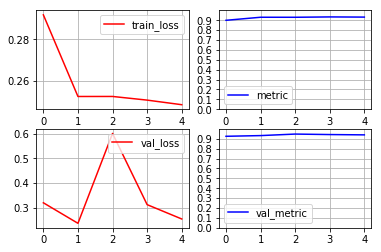

In [41]:
fig = plt.figure()
p1 = fig.add_subplot(221)
p2 = fig.add_subplot(222)
p3 = fig.add_subplot(223)
p4 = fig.add_subplot(224)
p2.set_ylim(0,1)
p4.set_ylim(0,1)
p1.grid()
p2.grid()
p3.grid()
p4.grid()
p2.set_yticks(np.arange(0,1,0.1))
p4.set_yticks(np.arange(0,1,0.1))
x = [i for i in range(5)]
y = results.history['loss']
y2 = results.history['metric']
y3 = results.history['val_loss']
y4 = results.history['val_metric']
p1.plot(x,y, 'r', label='train_loss')
p1.legend()
p2.plot(x,y2, 'b', label='metric')
p2.legend()
p3.plot(x,y3, 'r', label='val_loss')
p3.legend()
p4.plot(x,y4, 'b', label='val_metric')
p4.legend()
plt.show()

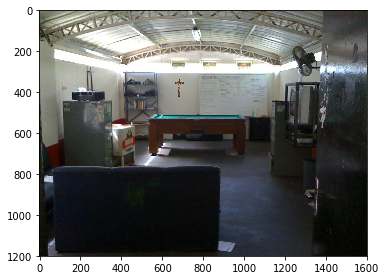

In [75]:
imshow(path_tampered+X_t[2][83:])

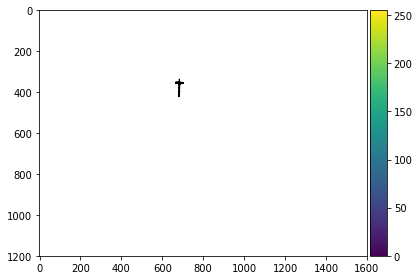

In [154]:
imshow(path_tampered+Y_t[2][98:])


In [117]:
model.load_weights('model_checkpoints/model_phase_2.hdf5')

In [47]:
test_images=LoadImages(X_t)
predicted=model.predict(test_images)

In [246]:
def plot_predicted_images(index):
    """Plots the predicted masks of tampered images"""
    #ret, bw_img = cv2.threshold((predicted[index]*255),127,255,cv2.THRESH_BINARY)
    plt.imsave('pred_mask.png',predicted[index])
    im_gray = cv2.imread('pred_mask.png', cv2.IMREAD_GRAYSCALE)
    (thresh, im_bw) = cv2.threshold(im_gray, 220, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    #imshow(im_bw)
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(441)
    ax2 = fig.add_subplot(442)
    ax3 = fig.add_subplot(443)
    ax4 = fig.add_subplot(444)
    
    ax1.set_title("actual_image")
    ax2.set_title("actual_mask")
    ax3.set_title("predicted_mask")
    ax4.set_title("binary_predicted_mask")
    actual_img = imread(path_tampered+X_t[index][83:])

    actual_mask = imread(Y_t[index])
    #predicted_mask = imread(predicted[0])

    
    ax1.imshow(actual_img)
    ax2.imshow(actual_mask)
    ax3.imshow(predicted[index])
    ax4.imshow(im_bw)
    
    



    

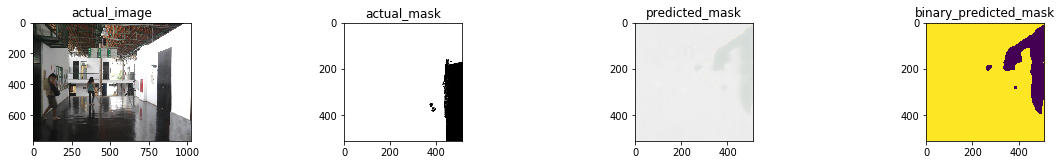

In [247]:
plot_predicted_images(16)

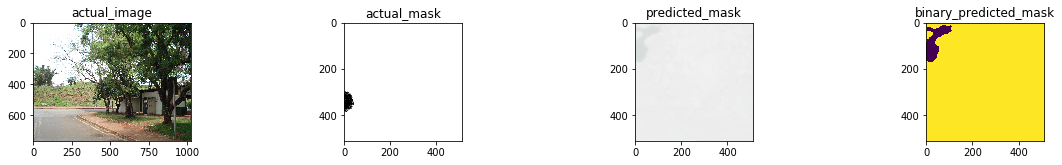

In [248]:
plot_predicted_images(1)

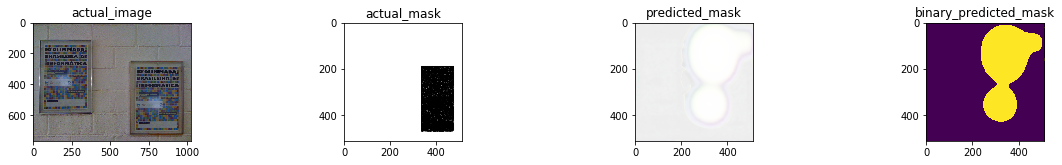

In [250]:
plot_predicted_images(9)

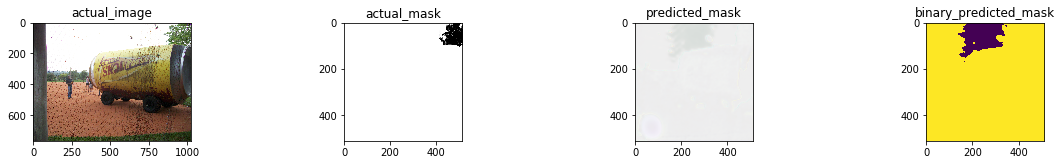

In [251]:
plot_predicted_images(19)

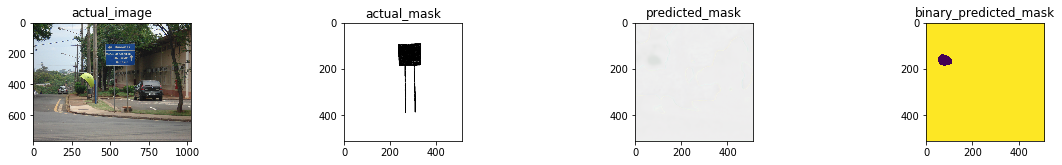

In [252]:
plot_predicted_images(40)

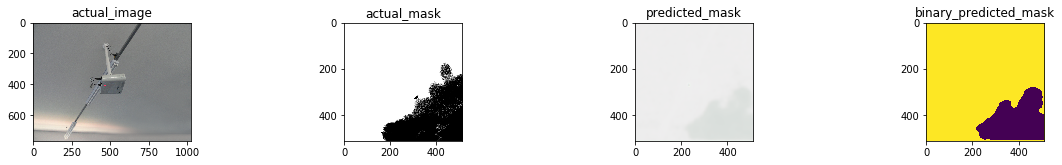

In [253]:
plot_predicted_images(42)

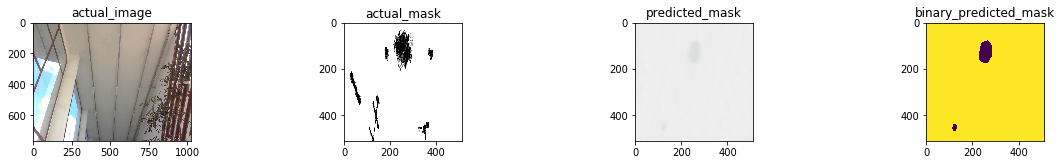

In [254]:
plot_predicted_images(43)

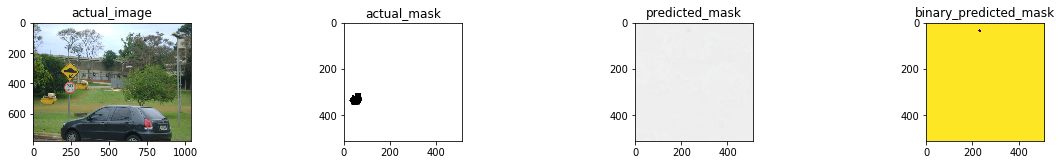

In [255]:
plot_predicted_images(48)

### Observation and Results:

* Used less points for training because system couldn't handle large numpy arrays.

* Model's eval_metric hit 0.94 at the end of 7 epochs.
* Although the model is average,it's still able to find out in what region the tampering has happened.
* So the results are a little better than average.



* There are better techniques to find out tampered sections of the image.




## ======================================================================= 

### Second approach:  SRM filter used to create the noise images

**Noise Analysis** – 
This is basically a reverse denoising algorithm. Rather than removing the noise, it removes the rest of the image. It is using a super simple separable median filter to isolate the noise. It can be useful for identifying manipulations to the image like airbrushing, deformations, warping, and perspective corrected cloning. It works best on high-quality images.



In [7]:
fakes = total_tampered
fake_path = path_tampered

In [8]:
os.makedirs('processed_images/')

In [11]:
import numpy as np
q = [4.0, 12.0, 2.0]
filter1 = [[0, 0, 0, 0, 0],
           [0, -1, 2, -1, 0],
           [0, 2, -4, 2, 0],
           [0, -1, 2, -1, 0],
           [0, 0, 0, 0, 0]]
filter2 = [[-1, 2, -2, 2, -1],
           [2, -6, 8, -6, 2],
           [-2, 8, -12, 8, -2],
           [2, -6, 8, -6, 2],
           [-1, 2, -2, 2, -1]]
filter3 = [[0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0],
           [0, 1, -2, 1, 0],
           [0, 0, 0, 0, 0],
           [0, 0, 0, 0, 0]]


filter1 = np.asarray(filter1, dtype=float) / q[0]
filter2 = np.asarray(filter2, dtype=float) / q[1]
filter3 = np.asarray(filter3, dtype=float) / q[2]
    
filters = filter1+filter2+filter3
for x in fakes:
    image = imread(fake_path+x)
    processed_image = cv2.filter2D(image,-1,filters)
    plt.imsave('processed_images/'+x,processed_image)




In [88]:
processed_images = os.listdir('processed_images/')

In [89]:
ip_img_filt= []
for i in tqdm(processed_images):
    if('.mask.png' not in i):
#         ip_img_filt.append(resize(imread('processed_images/'+i), (512, 512, 3)))
        ip_img_filt.append('processed_images/'+i)

100%|██████████| 900/900 [00:00<00:00, 178489.46it/s]


In [94]:

ip_fake_imgs = []
output_imgs = []
for i in tqdm(total_tampered):
    if('.mask.png' not in i):
#         ip_fake_imgs.append(resize(imread(path_tampered+i), (512, 512, 3)))
        ip_fake_imgs.append(path_tampered+i)
    if('.mask.png' in i):
        output_imgs.append(path_tampered+i)
#         output_imgs.append(resize(imread(path_tampered+i), (512, 512, 3)))
        


100%|██████████| 900/900 [00:00<00:00, 1459734.57it/s]


In [95]:
ip_img_filt.sort();ip_fake_imgs.sort();output_imgs.sort()

In [97]:
len(ip_img_filt),len(ip_fake_imgs),len(output_imgs)

(450, 450, 450)

In [106]:
X1_tr = np.array(ip_fake_imgs[0:369])
X2_tr = np.array(ip_img_filt[0:369])
Y_tr = np.array(output_imgs[0:369])

In [107]:
X1_val = np.array(ip_fake_imgs[369:len(ip_fake_imgs)])
X2_val = np.array(ip_img_filt[369:len(ip_img_filt)])
Y_val = np.array(output_imgs [369:len(output_imgs)])

In [18]:
X1_tr = np.array([resize(imread(file_name), (512, 512, 3)) for file_name in X1_tr])

In [19]:
X2_tr = np.array([resize(imread(file_name), (512, 512, 3)) for file_name in X2_tr])

In [20]:
Y_tr = np.array([resize(imread(file_name), (512, 512, 1)) for file_name in Y_tr])

In [21]:
X1_val = np.array([resize(imread(file_name), (512, 512, 3)) for file_name in X1_val])

In [22]:
X2_val = np.array([resize(imread(file_name), (512, 512, 3)) for file_name in X2_val])

In [23]:
Y_val = np.array([resize(imread(file_name), (512, 512, 1)) for file_name in Y_val])

In [27]:
save('/media/ubuntu/4430D4D130D4CAD6/X1_tr.npy',X1_tr)

In [28]:
save('/media/ubuntu/4430D4D130D4CAD6/X2_tr.npy',X2_tr)

In [29]:
save('/media/ubuntu/4430D4D130D4CAD6/Y_tr.npy',Y_tr)

In [30]:
save('/media/ubuntu/4430D4D130D4CAD6/X1_val.npy',X1_val)

In [31]:
save('/media/ubuntu/4430D4D130D4CAD6/X2_val.npy',X2_val)

In [32]:
save('/media/ubuntu/4430D4D130D4CAD6/Y_val.npy',Y_val)

In [4]:
X1_tr = load('/media/ubuntu/4430D4D130D4CAD6/X1_tr.npy')

In [5]:
X2_tr = load('/media/ubuntu/4430D4D130D4CAD6/X2_tr.npy')

In [6]:
Y_tr = load('/media/ubuntu/4430D4D130D4CAD6/Y_tr.npy')

In [7]:
X1_val = load('/media/ubuntu/4430D4D130D4CAD6/X1_val.npy')

In [8]:
X2_val = load('/media/ubuntu/4430D4D130D4CAD6/X2_val.npy')

In [9]:
Y_val = load('/media/ubuntu/4430D4D130D4CAD6/Y_val.npy')

In [10]:

def conv2d_block(input_dim, n_filters, kernel_size=3, batchnorm=True):
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",padding="same") (input_dim)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",padding="same")(x)
    x = BatchNormalization()(x)
    final_block = Activation("relu")(x)
    return final_block


In [11]:
input_img = Input((512, 512, 3), name='img1')
n_filters=16
batchnorm=True
dropout=0.5
# contracting path
c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
p1 = MaxPooling2D((2, 2)) (c1)
p1 = Dropout(dropout*0.5)(p1)
c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
p2 = MaxPooling2D((2, 2)) (c2)
p2 = Dropout(dropout)(p2)
c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
p3 = MaxPooling2D((2, 2)) (c3)
p3 = Dropout(dropout)(p3)
c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
p4 = Dropout(dropout)(p4)
c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
#Expanding path
u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
#skip_connections
u6 = concatenate([u6, c4])
u6 = Dropout(dropout)(u6)
c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
u7 = Dropout(dropout)(u7)
c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
u8 = Dropout(dropout)(u8)
c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
u9 = Dropout(dropout)(u9)
c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)

output = Conv2D(3, (1, 1), activation='sigmoid') (c9)
#model1 = Model(inputs=[input_img], outputs=[outputs])

input_img_filter = Input((512, 512, 3), name='img2')
n_filters=16
batchnorm=True
dropout=0.5

# contracting path
c1 = conv2d_block(input_img_filter, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
p1 = MaxPooling2D((2, 2)) (c1)
p1 = Dropout(dropout*0.5)(p1)
c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
p2 = MaxPooling2D((2, 2)) (c2)
p2 = Dropout(dropout)(p2)
c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
p3 = MaxPooling2D((2, 2)) (c3)
p3 = Dropout(dropout)(p3)
c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
p4 = Dropout(dropout)(p4)
c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
#Expanding path
u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
#skip_connections
u6 = concatenate([u6, c4])
u6 = Dropout(dropout)(u6)
c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
u7 = Dropout(dropout)(u7)
c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
u8 = Dropout(dropout)(u8)
c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
u9 = Dropout(dropout)(u9)
c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)

output_filter = Conv2D(3, (1, 1), activation='sigmoid') (c9)

combined = concatenate([output, output_filter])
outputs = Conv2D(1, (1, 1), activation='sigmoid') (combined)

model = Model(inputs=[input_img,input_img_filter], outputs=[outputs])
##model inputs = fake,image and noise filter
## model output = ground truth mask

In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img1 (InputLayer)               (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
img2 (InputLayer)               (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 448         img1[0][0]                       
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 512, 512, 16) 448         img2[0][0]                       
____________________________________________________________________________________________

In [13]:
def metric(y_true, y_pred, smooth=1): # Dice_Coeff or F-Score
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [14]:
model.compile(optimizer=optimizers.Adam(), loss="binary_crossentropy", metrics=[metric])

In [15]:
history = model.fit([X1_tr,X2_tr], [Y_tr],validation_data=([X1_val,X2_val], [Y_val]),epochs=30, batch_size=3,verbose=1)


Train on 369 samples, validate on 81 samples
Epoch 1/30
369/369 [==============================] - 65s 175ms/step - loss: 0.3680 - metric: 0.8298 - val_loss: 0.2462 - val_metric: 0.8989
Epoch 2/30
369/369 [==============================] - 52s 142ms/step - loss: 0.2795 - metric: 0.8921 - val_loss: 0.2198 - val_metric: 0.9191
Epoch 3/30
369/369 [==============================] - 52s 140ms/step - loss: 0.2614 - metric: 0.9119 - val_loss: 0.2117 - val_metric: 0.9265
Epoch 4/30
369/369 [==============================] - 52s 140ms/step - loss: 0.2565 - metric: 0.9204 - val_loss: 0.2051 - val_metric: 0.9337
Epoch 5/30
369/369 [==============================] - 52s 140ms/step - loss: 0.2547 - metric: 0.9240 - val_loss: 0.2024 - val_metric: 0.9369
Epoch 6/30
369/369 [==============================] - 52s 140ms/step - loss: 0.2540 - metric: 0.9262 - val_loss: 0.2040 - val_metric: 0.9335
Epoch 7/30
369/369 [==============================] - 52s 140ms/step - loss: 0.2538 - metric: 0.9243 - val_lo

In [16]:
model.save('srm_filter.h5')

In [48]:
# from keras.models import load_model
# model = load_model('/media/ubuntu/4430D4D130D4CAD6/srm_filter_model.h5',custom_objects={'metric': metric})

dict_keys(['val_loss', 'val_metric', 'loss', 'metric'])


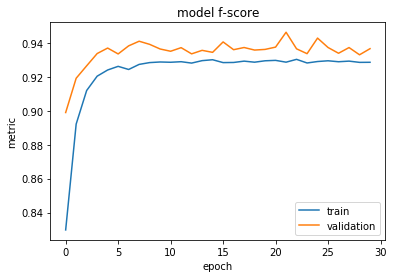

In [17]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['metric'])
plt.plot(history.history['val_metric'])
plt.title('model f-score')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='bottom right')
plt.show()


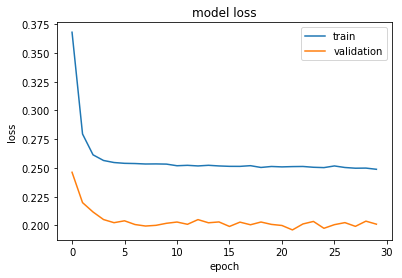

In [18]:
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

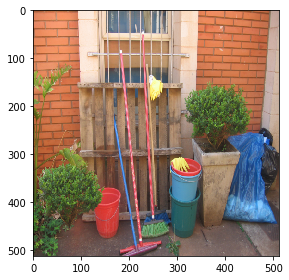

In [53]:
imshow(X1_val[51])

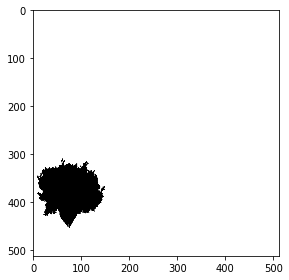

In [54]:
#https://stackoverflow.com/questions/54664329/invalid-dimension-for-image-data-in-plt-imshow
imshow(np.squeeze(Y_val[51]))

In [19]:
prediction = model.predict([X1_val,X2_val])

In [20]:
prediction

array([[[[0.90898734],
         [0.9319059 ],
         [0.93278444],
         ...,
         [0.942628  ],
         [0.94057876],
         [0.9349943 ]],

        [[0.93084896],
         [0.9432395 ],
         [0.9465352 ],
         ...,
         [0.9509248 ],
         [0.94965774],
         [0.9468682 ]],

        [[0.93091446],
         [0.9448514 ],
         [0.94667184],
         ...,
         [0.952221  ],
         [0.9513067 ],
         [0.9488663 ]],

        ...,

        [[0.93044704],
         [0.9418011 ],
         [0.9438441 ],
         ...,
         [0.9541707 ],
         [0.95413846],
         [0.9525647 ]],

        [[0.92820644],
         [0.9432017 ],
         [0.94527256],
         ...,
         [0.9536649 ],
         [0.95224154],
         [0.94890815]],

        [[0.90827066],
         [0.9319673 ],
         [0.9327078 ],
         ...,
         [0.9432888 ],
         [0.9418198 ],
         [0.93959993]]],


       [[[0.9133786 ],
         [0.93569994],
         [0.93

In [18]:
prediction.shape

(81, 512, 512, 1)

In [21]:
def plot_predicted_images(index):
    """Plots the predicted masks of tampered images"""
    pred = np.squeeze(prediction[index])
    plt.imsave('pred_mask.png',pred)
    im_gray = cv2.imread('pred_mask.png', cv2.IMREAD_GRAYSCALE)
    (thresh, im_bw) = cv2.threshold(im_gray, 220, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(331)
    ax2 = fig.add_subplot(332)
    ax3 = fig.add_subplot(333)
    
    
    ax1.set_title("actual_image")
    ax2.set_title("actual_mask")
    ax3.set_title("predicted_mask")
    ax1.imshow(X1_val[index])
    ax2.imshow(np.squeeze(Y_val[index]))
    ax3.imshow(im_bw)   

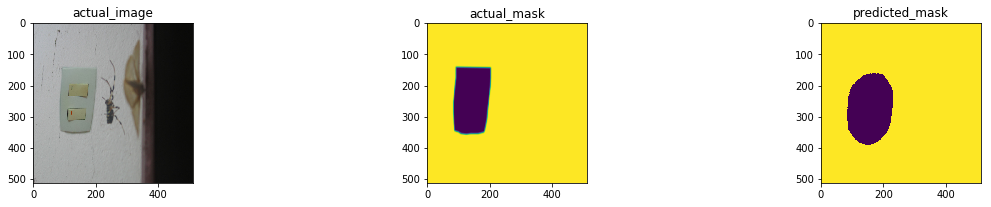

In [140]:
plot_predicted_images(77)

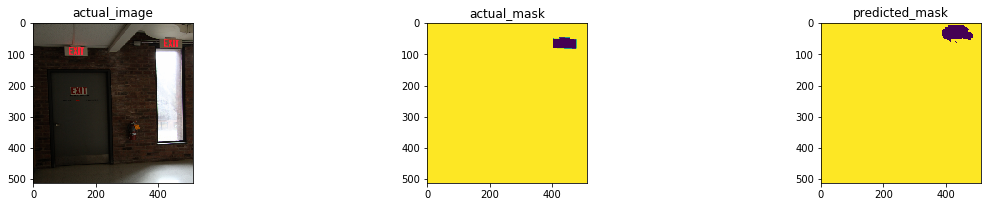

In [117]:
plot_predicted_images(55)

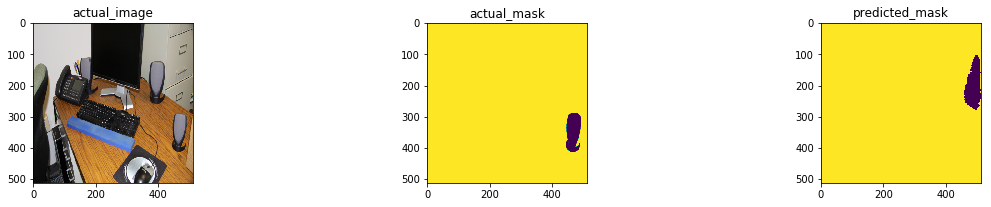

In [66]:
plot_predicted_images(4)

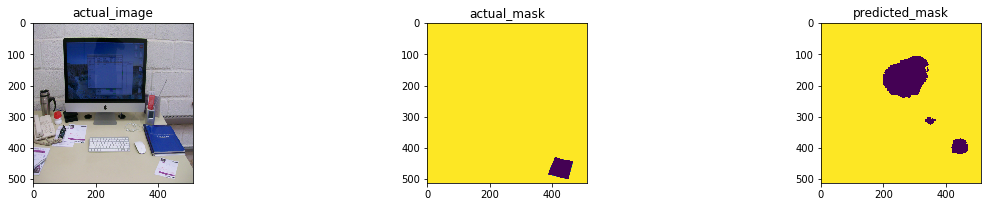

In [105]:
plot_predicted_images(43)

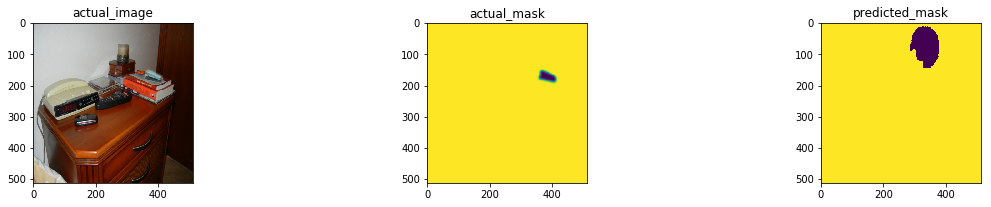

In [126]:
plot_predicted_images(63)

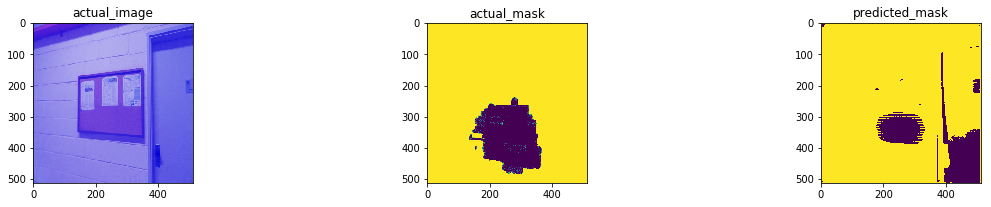

In [35]:
plot_predicted_images(13)

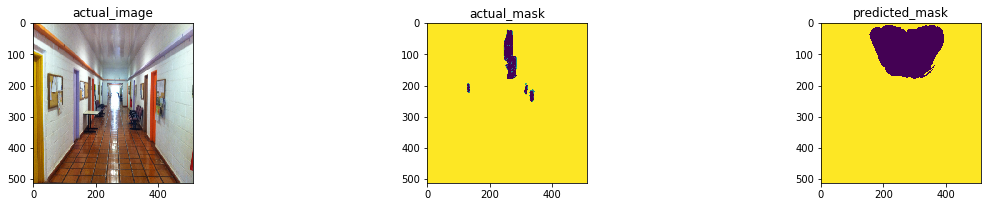

In [97]:
plot_predicted_images(35)

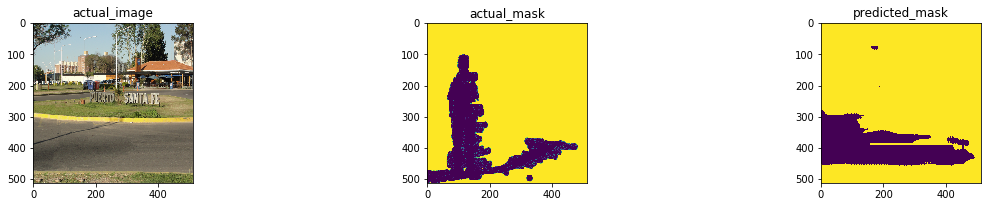

In [33]:
plot_predicted_images(11)

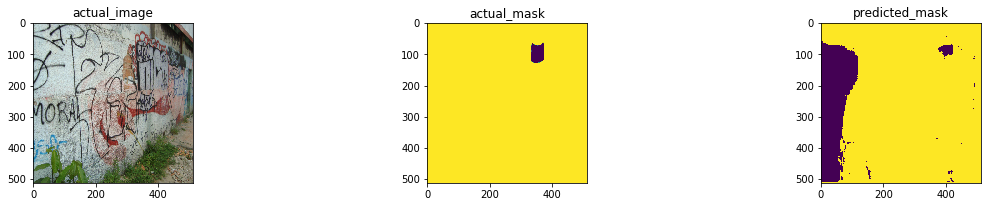

In [46]:
plot_predicted_images(24)

### Observation:

* We find that the results of the model with SRM filter with Fake images seem to be somewhat same as what we had got before.



In [2]:
# Please compare all your models using Prettytable library
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
#If you get a ModuleNotFoundError error ,pip install prettytable

x = PrettyTable()
x.field_names = ["Model","Metric",  "Score"]

x.add_row(["Unet-ELA+Mask","Train (F score)", 0.93])
x.add_row(["Unet-ELA+Mask","Validation (F score)", 0.94])
x.add_row(["-"*30,"-"*30, "-"*30])
x.add_row(["Fakes+SRM Filter","Train (F score)", 0.9286])
x.add_row(["Fakes+SRM Filter","Validation(F score)", 0.9366])

print(x)


+--------------------------------+--------------------------------+--------------------------------+
|             Model              |             Metric             |             Score              |
+--------------------------------+--------------------------------+--------------------------------+
|         Unet-ELA+Mask          |        Train (F score)         |              0.93              |
|         Unet-ELA+Mask          |      Validation (F score)      |              0.94              |
| ------------------------------ | ------------------------------ | ------------------------------ |
|        Fakes+SRM Filter        |        Train (F score)         |             0.9286             |
|        Fakes+SRM Filter        |      Validation(F score)       |             0.9366             |
+--------------------------------+--------------------------------+--------------------------------+


### Sources and References used for this assignment:

* https://en.wikipedia.org/wiki/U-Net

* https://www.jeremyjordan.me/semantic-segmentation/

* https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47